# Processing RAVDESS dataset

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

**Filename identifiers**

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).



In [13]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
data_dir = "../input/ravdess"
data = []
for actor in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, actor)):
        for file in os.listdir(os.path.join(data_dir, actor)):
            filepath = os.path.join(actor, file)
            data.append([filepath]+os.path.splitext(file)[0].split("-"))

In [3]:
df = pd.DataFrame(data, columns=["filepath", "modality", "vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor_id"])

In [4]:
df.tail()

,filepath,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor_id
1435,Actor_03/03-01-04-02-02-02-03.wav,03,01,04,02,02,02,03
1436,Actor_03/03-01-05-02-01-01-03.wav,03,01,05,02,01,01,03
1437,Actor_03/03-01-04-02-01-01-03.wav,03,01,04,02,01,01,03
1438,Actor_03/03-01-06-01-02-01-03.wav,03,01,06,01,02,01,03
1439,Actor_03/03-01-03-01-01-02-03.wav,03,01,03,01,01,02,03


In [5]:
# Modality and vocal channel are same for all audio files
no_info_columns = []
for c in df.columns:
    if df[c].nunique()==1:
        no_info_columns.append(c)
df.drop(no_info_columns, axis=1, inplace=True)

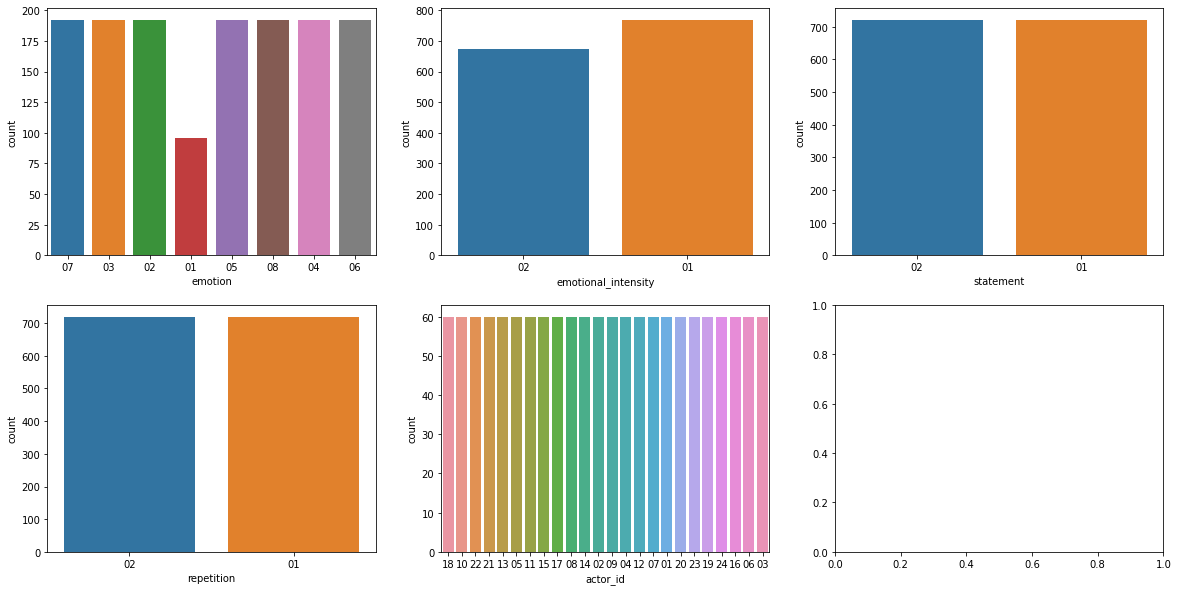

In [6]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10), facecolor="white")
for i, col in enumerate(["emotion","emotional_intensity","statement","repetition","actor_id"]):
    r,c = i//3, i%3
    sns.countplot(x=col, data=df, ax=ax[r,c])
plt.show()

## Split
- Method1
    - Holdout 1 male and 1 female actor randomly
    - Do 75-25 split for train and validation data respectively.
    - This will give us:
        - Test samples = 120 (8.34%)
        - Validation samples = 330 (22.92%)
        - Train samples = 990 (68.75%)
- Method2

In [7]:
def _initialize_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

random_state = 42
_initialize_seed(random_state)

In [14]:
def method1(df):
    df = df.copy()
    # Take out test dataset
    actor_ids = df["actor_id"].unique()
    actor_test_id1 = np.random.choice([x for x in actor_ids if int(x)%2==0])
    actor_test_id2 = np.random.choice([x for x in actor_ids if int(x)%2==1])
    print("Actor test ids:", actor_test_id1, "and", actor_test_id2)

    df_test = df[df["actor_id"].isin([actor_test_id1,actor_test_id2])]
    df = df[~df["actor_id"].isin([actor_test_id1,actor_test_id2])]
    print("Length of test dataset:", len(df_test))
    print("Remaining samples:", len(df))

    # Split rest into train and valid
    df_train, df_valid = train_test_split(
        df,
        stratify=df["emotion"]+"-"+df["actor_id"],
        test_size=0.25,
        random_state=random_state,
    )

    print("Length of train dataset:", len(df_train))
    print("Length of validation dataset:", len(df_valid))

    # Encode labels to ids
    label_encoder = LabelEncoder()
    df_train["emotion"] = label_encoder.fit_transform(df_train["emotion"])
    df_valid["emotion"] = label_encoder.transform(df_valid["emotion"])
    df_test["emotion"] = label_encoder.transform(df_test["emotion"])

    print("Labels:", label_encoder.classes_)
    print("IDs:", label_encoder.transform(label_encoder.classes_))
    
    # Save
    df_train.to_csv(os.path.join(data_dir, "train.csv"), index=False)
    df_valid.to_csv(os.path.join(data_dir, "valid.csv"), index=False)
    df_test.to_csv(os.path.join(data_dir, "test.csv"), index=False)

In [18]:
def method2(df):
    # Bifurcate emotion by gender
    df = df.copy()
    df.loc[:, "emotion"] += "-"+(df["actor_id"].astype(np.uint8)%2).astype(str)
    
    # Take out test dataset
    actor_ids = df["actor_id"].unique()
    actor_test_id1 = np.random.choice([x for x in actor_ids if int(x)%2==0])
    actor_test_id2 = np.random.choice([x for x in actor_ids if int(x)%2==1])
    print("Actor test ids:", actor_test_id1, "and", actor_test_id2)

    df_test = df[df["actor_id"].isin([actor_test_id1,actor_test_id2])]
    df = df[~df["actor_id"].isin([actor_test_id1,actor_test_id2])]
    print("Length of test dataset:", len(df_test))
    print("Remaining samples:", len(df))

    # Split rest into train and valid
    df_train, df_valid = train_test_split(
        df,
        stratify=df["emotion"],
        test_size=0.25,
        random_state=random_state,
    )

    # Encode labels to ids
    label_encoder = LabelEncoder()
    df_train["emotion"] = label_encoder.fit_transform(df_train["emotion"])
    df_valid["emotion"] = label_encoder.transform(df_valid["emotion"])
    df_test["emotion"] = label_encoder.transform(df_test["emotion"])

    print("Labels:", label_encoder.classes_)
    print("IDs:", label_encoder.transform(label_encoder.classes_))

    print("Length of train dataset:", len(df_train))
    print("Length of validation dataset:", len(df_valid))

    # Save
    df_train.to_csv(os.path.join(data_dir, "train.csv"), index=False)
    df_valid.to_csv(os.path.join(data_dir, "valid.csv"), index=False)
    df_test.to_csv(os.path.join(data_dir, "test.csv"), index=False)

In [19]:
method2(df)

Actor test ids: 04 and 19
Length of test dataset: 120
Remaining samples: 1320
Labels: ['01-0' '01-1' '02-0' '02-1' '03-0' '03-1' '04-0' '04-1' '05-0' '05-1'
 '06-0' '06-1' '07-0' '07-1' '08-0' '08-1']
IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Length of train dataset: 990
Length of validation dataset: 330
